# Evaluación inicial de modelos de audio TensorFlow Lite

Este notebook sirve para probar el funcionamiento de un modelo de audio TensorFlow Lite.
## Imports

In [1]:
import tensorflow as tf
import os
from joblib import load
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import time

from audio_model_evaluation import get_dataset, DIGITS

## Parámetros
Parámetros que se utilizan para el test.

In [2]:
quantized = True
project_dir = "/home/daniel/PycharmProjects/tfg-tinyml"
saved_models_dir = f"{project_dir}/saved models/audio"
label_index_dir = f"{saved_models_dir}/label index mappings"
# model_name = f"ExtAudioDataModel"
model_name = f"ExtAudioDataModelQAT"

label_index_path = f"{label_index_dir}/{model_name}.joblib"
test_dir = f"{project_dir}/samples/external/audio/test"

if quantized and model_name[-3:] != "QAT":
    model_name = f"{model_name}Quant"

model_path = f"{saved_models_dir}/tensorflow lite/{model_name}.tflite"

## Carga del modelo
Cargamos un modelo de TensorFlow Lite.

In [3]:
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

print(input_details)
print(output_details)

class_names = load(label_index_path)
class_indexes = {}
for index, name in enumerate(class_names):
    class_indexes[name] = index

{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 40, 49,  1], dtype=int32), 'shape_signature': array([-1, 40, 49,  1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.3137255311012268, 127), 'quantization_parameters': {'scales': array([0.31372553], dtype=float32), 'zero_points': array([127], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'StatefulPartitionedCall:0', 'index': 9, 'shape': array([1, 4], dtype=int32), 'shape_signature': array([-1,  4], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.3091215491294861, 81), 'quantization_parameters': {'scales': array([0.30912155], dtype=float32), 'zero_points': array([81], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


## Carga de datos

Cargamos los datos que se utilizarán para el entrenamiento.

In [4]:
test_dataset = get_dataset(test_dir, prefetch=False)
test_dataset = test_dataset.as_numpy_iterator()

Using 3230 samples.
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


## Inferencia
Se realiza inferencia sobre los archivos de la carpeta test y se muestran los resultados.

In [5]:
predictions = []
true_labels = []
times = []

for spectrogram, label in test_dataset:
    true_labels.append(label)

    if quantized:
        input_scale, input_zero_point = input_details["quantization"]
        spectrogram = spectrogram / input_scale + input_zero_point
    spectrogram = np.expand_dims(spectrogram, axis=0).astype(input_details["dtype"])

    interpreter.set_tensor(input_details["index"], spectrogram)

    t_ini = time.time()
    interpreter.invoke()
    t_end = time.time()
    elapsed = (t_end - t_ini) * 1000  # ms
    times.append(elapsed)

    prediction = interpreter.get_tensor(output_details["index"])[0]

    predicted_class = prediction.argmax()
    predictions.append(predicted_class)

## Visualización de métricas

Se muestran datos acerca del comportamiento general del modelo al evaluar las muestras.

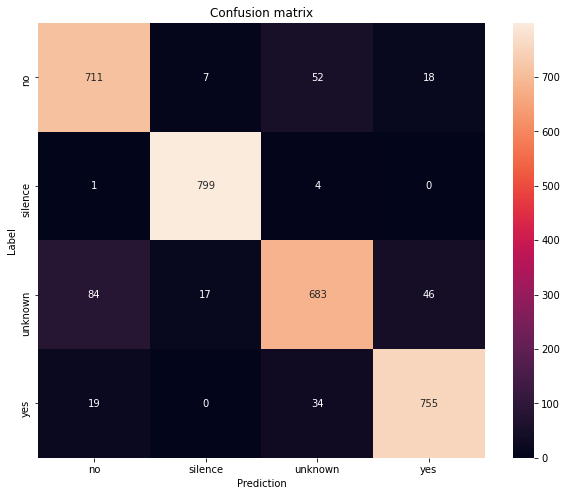

              precision    recall  f1-score   support

          no    0.87239   0.90228   0.88709       788
     silence    0.97084   0.99378   0.98218       804
     unknown    0.88357   0.82289   0.85215       830
         yes    0.92186   0.93441   0.92809       808

    accuracy                        0.91269      3230
   macro avg    0.91216   0.91334   0.91238      3230
weighted avg    0.91214   0.91269   0.91204      3230

Model size 5.609375 Kb
Average time: 1.4733555147153305 ms
Max time: 6.808996200561523 ms
Min time: 0.6239414215087891 ms
Quantized models perform slower as they are intended to work on ARM devices.


In [6]:
confusion_mtx = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=class_names, yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title("Confusion matrix")
plt.show()
print(classification_report(true_labels, predictions, target_names=class_names, digits=DIGITS))

avg_time = sum(times) / len(times)
max_time = max(times)
min_time = min(times)

print(f"Model size {os.path.getsize(model_path) / 1024} Kb")

print(f"Average time: {avg_time} ms\nMax time: {max_time} ms\nMin time: {min_time} ms")

if quantized:
    print("Quantized models perform slower as they are intended to work on ARM devices.")